# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# 머신러닝/데이터 처리 라이브러리
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_transformer

# 텐서플로우 및 케라스
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# 설정
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 10

2024-10-29 21:50:38.818724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 21:50:38.825471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 21:50:38.833032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 21:50:38.835299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 21:50:38.840997: I tensorflow/core/platform/cpu_feature_guar

# Model Test

In [2]:
positive_data = pd.read_csv('dataset/positive_test_data.csv')
negative_data = pd.read_csv('dataset/negative_test_data.csv')
autoencoder = load_model('dataset/unsupervised_autoencoder.keras')

I0000 00:00:1730206239.429447 1454840 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730206239.459620 1454840 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730206239.459721 1454840 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730206239.461270 1454840 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# 'dataset_type' 열을 삭제합니다
positive_data = positive_data.drop(columns=['dataset_type'])
negative_data = negative_data.drop(columns=['dataset_type'])

# 문자열 형태의 벡터 데이터를 실제 리스트로 변환합니다
positive_data['descendant_classes_encoded'] = positive_data['descendant_classes_encoded'].apply(eval)
negative_data['descendant_classes_encoded'] = negative_data['descendant_classes_encoded'].apply(eval)

positive_data['classified_class_encoded'] = positive_data['classified_class_encoded'].apply(eval)
negative_data['classified_class_encoded'] = negative_data['classified_class_encoded'].apply(eval)

In [4]:
# PCA를 사용하여 차원 축소
def pca(data, n_components=4):
    vectors = np.stack(data['descendant_classes_encoded'].values)
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(vectors)
    return reduced_vectors

# positive_data와 negative_data에 대해 PCA 적용
positive_vectors_reduced = pca(positive_data)
negative_vectors_reduced = pca(negative_data)

# classified_classes_encoded를 그대로 벡터로 추가
positive_classified_vectors = np.stack(positive_data['classified_class_encoded'].values)
negative_classified_vectors = np.stack(negative_data['classified_class_encoded'].values)

# 다른 피처와 결합하여 모델 입력 형식으로 준비
positive_features = positive_data.drop(columns=['descendant_classes_encoded', 'classified_class_encoded']).values
negative_features = negative_data.drop(columns=['descendant_classes_encoded', 'classified_class_encoded']).values

positive_input = np.concatenate([positive_features, positive_vectors_reduced, positive_classified_vectors], axis=1)
negative_input = np.concatenate([negative_features, negative_vectors_reduced, negative_classified_vectors], axis=1)

In [5]:
# Autoencoder를 사용하여 재구성 오류 계산
reconstructions_positive = autoencoder.predict(positive_input, verbose=0)
reconstructions_negative = autoencoder.predict(negative_input, verbose=0)

# 입력값과 재구성된 값 사이의 MSE 측정
mse_positive = np.mean(np.power(positive_input - reconstructions_positive, 2), axis=1)
mse_negative = np.mean(np.power(negative_input - reconstructions_negative, 2), axis=1)

I0000 00:00:1730206240.064337 1454986 service.cc:146] XLA service 0x7cf63c006bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730206240.064359 1454986 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-29 21:50:40.069033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 21:50:40.092733: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1730206240.387579 1454986 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


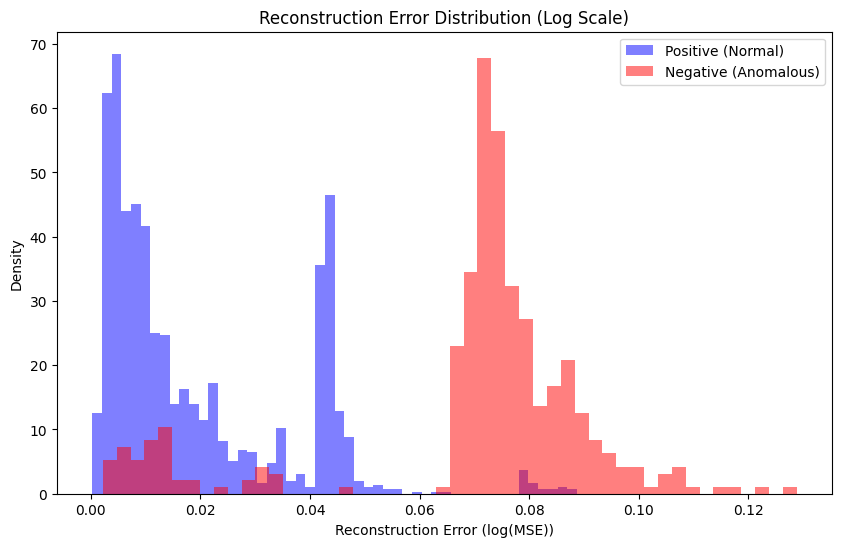

In [6]:
# 3. 재구성 오류 히스토그램 그리기
plt.figure(figsize=(10, 6))

# 정상 데이터의 재구성 오류 분포 
plt.hist(np.log1p(mse_positive), bins=50, alpha=0.5, label='Positive (Normal)', color='blue', density=True)

# 이상 데이터의 재구성 오류 분포 
plt.hist(np.log1p(mse_negative), bins=50, alpha=0.5, label='Negative (Anomalous)', color='red', density=True)

# 그래프 정보 추가
plt.title('Reconstruction Error Distribution (Log Scale)')
plt.xlabel('Reconstruction Error (log(MSE))')
plt.ylabel('Density')
plt.legend(loc='upper right')

# 그래프 표시
plt.show()

In [7]:
# 3. 재구성 오류를 하나의 배열로 결합하고, 라벨링 (정상: 0, 이상: 1)
reconstruction_error = np.concatenate([mse_positive, mse_negative])
labels = np.concatenate([np.zeros(len(mse_positive)), np.ones(len(mse_negative))])

# 재구성 오류와 실제 라벨을 데이터프레임에 저장
recons_df = pd.DataFrame({'error': reconstruction_error, 'label': labels})

In [22]:
# 성능 지표 및 혼동행렬 계산 함수 정의
def calculate_metrics(df, threshold):
    # 예측 값 생성: 임계값을 넘으면 이상치로 간주
    y_pred = (df['error'] > threshold).astype(int)

    # 성능 지표 계산
    precision = precision_score(df['label'], y_pred)
    recall = recall_score(df['label'], y_pred)
    f1 = f1_score(df['label'], y_pred)
    accuracy = accuracy_score(df['label'], y_pred)

    # 혼동행렬 계산
    conf_matrix = confusion_matrix(df['label'], y_pred)

    return precision, recall, f1, accuracy, conf_matrix

# 임계값 설정 
threshold = np.percentile(recons_df['error'],82.75)

# 성능 지표 및 혼동행렬 계산
precision, recall, f1, accuracy, conf_matrix = calculate_metrics(recons_df, threshold)

# 성능 지표 출력
print(f"Threshold: {threshold:.4f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Threshold: 0.0668
Precision: 0.929
Recall: 0.868
F1 Score: 0.897
Accuracy: 0.963


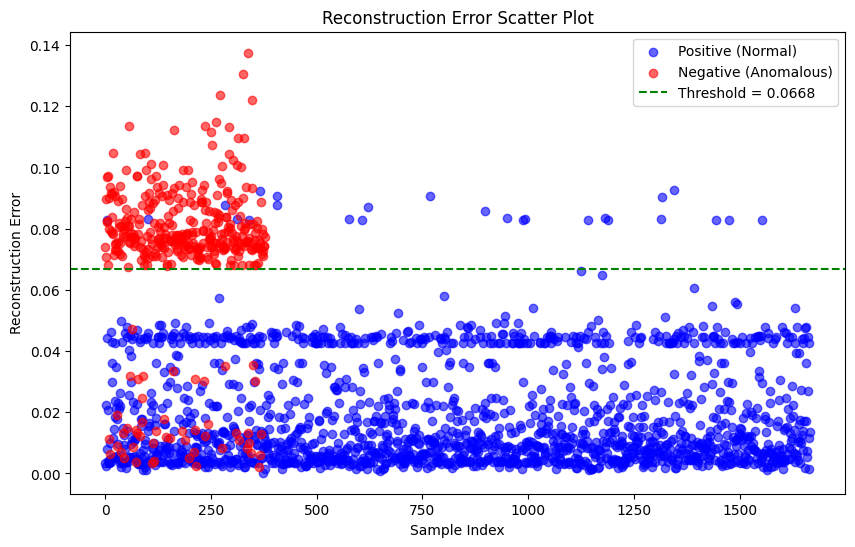

In [23]:
# 재구성 오류 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mse_positive)), mse_positive, color='blue', alpha=0.6, label='Positive (Normal)')
plt.scatter(range(len(mse_negative)), mse_negative, color='red', alpha=0.6, label='Negative (Anomalous)')
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Scatter Plot')
plt.legend(loc='upper right')
plt.show()

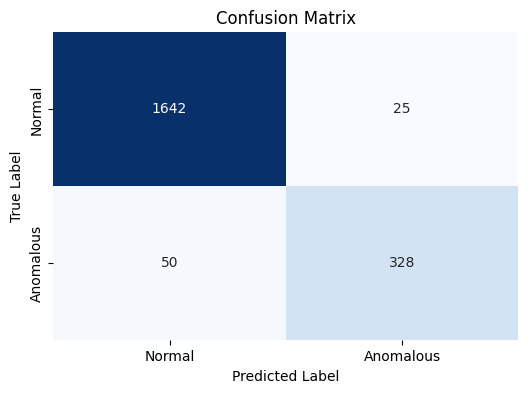

In [24]:
# 혼동행렬 시각화
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Anomalous'],
            yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(f"Recall Score (Anomalous Detection): {recall * 100:.3f}%")
print(f"Accuracy Score: {accuracy * 100:.3f}%")

Recall Score (Anomalous Detection): 86.772%
Accuracy Score: 96.333%


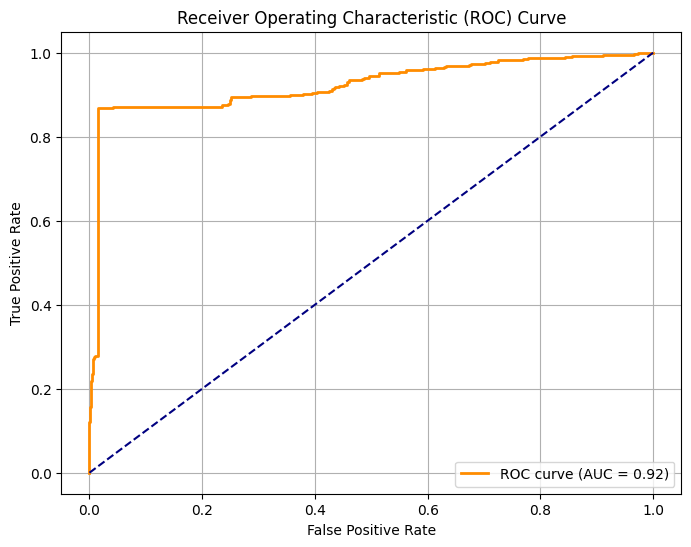

In [26]:
# 실제 라벨과 재구성 오류를 사용하여 ROC 커브를 그리기 위해 라벨 준비
y_true = recons_df['label']
y_scores = recons_df['error']

# ROC 커브 계산
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [13]:
# AUC 출력
print(f"AUC: {roc_auc:.3f}")

AUC: 0.924
